# Berry Cox's Price Momentum Final Project - Justin & Defne 

---
## Primary Objective: Select Baskets of Assets for a long-short portfolio based on Berry Cox's Prcie Momentum Factors. Backtest for 5 years to check the performance of the algorithm.
---

### Step 1: Choose an ETF with a minimum of 100 assets, identify those assets
- We're using IVV ETF (IShares Core S&P 500 ETF)
- We have a [CSV file](https://www.ishares.com/us/products/239726/ishares-core-sp-500-etf) with all their holdings to extract their assets
- We'll download the asset information with Yahoo Finance

### Step 2: Retrieve historical data for your chosen ETF
- Using Adj Close for both, the IVV ETF and IVV Asset data

In [131]:
# Importing our module 
import yfinance as yf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Retrieving Data for our chosen etf
ivv_etf = yf.download('iVV', period='5y')['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [19]:
# Retrieving Data for our assets 

"""
5 Failed downloads:
- BRKB: No data found, symbol may be delisted
- ESM3: No data found, symbol may be delisted
- UBFUT: No data found, symbol may be delisted
- XTSLA: No data found, symbol may be delisted
- BFB: No data found, symbol may be delisted

Since there's no data on these tickers we're just going to remove them from our dataframe
"""
ivv_assets_df = pd.read_csv('IVV_holdings.csv')[['Ticker', 'Name']].dropna()
ivv_assets_df = ivv_assets_df.drop(index=ivv_assets_df.loc[ivv_assets_df['Ticker'].isin(['BRKB', 'ESM3', 'XTSLA', "UBFUT", "XTSLA", "BFB"])].index.tolist())
ivv_asset_data = yf.download(tickers=ivv_assets_df['Ticker'].tolist(), period='5y')['Adj Close']  # accounting for the previous 5 years worth of data to help with the backtest 

[*********************100%***********************]  502 of 502 completed


### Step 3: Calculate the price momentum factors for each asset in your ETF
- Focusing on the 30 Day Price Momentum 

`Price Momentum = (CP - CPn) / CPn`

Where: 
- CP = Closing price in the current period
- CPn = Closing price N periods ago

### Step 4: Using the price momentum factors, calculate the monthly z-factor score for each asset
[Z-Factor Score Formula](https://www.khanacademy.org/math/statistics-probability/modeling-distributions-of-data/z-scores/a/z-scores-review)

`Z-Factor Score = (Monthly Price Momentum Factor - Monthly Mean of Percent Change) / Monthly Standard Deviation`

In [212]:
# Building a Python Class for our portfolio 

class Portfolio:
    def __init__(self, etf_name, etf_data, etf_assets_df, etf_assets_data_df):
            self.etf_name = etf_name
            self.etf_data = etf_data # Current ETF Data (no assets information)
            self.etf_assets_df = etf_assets_df # houses all the Tickers and Name for every asset in our ETF
            self.etf_assets_data_df = etf_assets_data_df # getting the actually Adj Close Price of all our assets
            self.etf_asset_info = pd.DataFrame(index=self.etf_assets_df['Ticker']) # Newly created DF to use Basket Information
            
            # monthly data
            self.monthly_mean = self.etf_assets_data_df.groupby(pd.Grouper(freq='M')).mean()
            self.monthly_std = self.etf_assets_data_df.pct_change().groupby(pd.Grouper(freq='M')).std()
            
    def get_baskets(self):
        # Price Momentum Factor
        self.etf_asset_info['Price Momentum Factor'] = (self.etf_assets_data_df.iloc[-1] - self.etf_assets_data_df.iloc[-31]) / self.etf_assets_data_df.iloc[-31]
        
        # Monthly Z-Factor Score  
        monthly_pct_change_mean = self.etf_assets_data_df.pct_change().groupby(pd.Grouper(freq='M')).mean()
        monthly_z_factor = (self.etf_asset_info['Price Momentum Factor'] - monthly_pct_change_mean.iloc[-1])/self.monthly_std.iloc[-1]
        self.etf_asset_info['Monthly Z-Factor Score'] = abs(monthly_z_factor)
        return self.etf_asset_info
    
    def get_smallest_basket(self):
        # Getting 15 Smallest Z-factor Score for 15 Short Stocks 
        total_baskets = self.get_baskets()
        smallest_basket = total_baskets.loc[total_baskets.index.isin(total_baskets['Monthly Z-Factor Score'].nsmallest(15).index.tolist())].sort_values('Monthly Z-Factor Score', )
        return smallest_basket
        
    def get_largest_basket(self):
        # Getting 15 Largest Z-factor Score for 15 Long Stocks 
        total_baskets = self.get_baskets()
        largest_basket = total_baskets.loc[total_baskets.index.isin(total_baskets['Monthly Z-Factor Score'].nlargest(15).index.tolist())].sort_values('Monthly Z-Factor Score', )
        return largest_basket
    
    def get_portfolio_basket(self):
        # Returns the combination of 15 Long stocks and 15 Short Stocks
        return pd.concat([self.get_smallest_basket(),self.get_largest_basket()]).sort_values('Monthly Z-Factor Score', ascending=False)
    
    def get_monthly_info(self,basket):
        port_monthly_mean = self.monthly_mean[basket.index.tolist()].copy()
        port_monthly_mean['Portfolio Monthly Return'] = port_monthly_mean[basket.index.tolist()].sum(axis=1)
        port_monthly_mean['Portfolio Precent Change'] = port_monthly_mean[basket.index.tolist()].pct_change().sum(axis=1)
        port_monthly_mean['Cumulative Monthly Return'] = port_monthly_mean['Portfolio Monthly Return'].cumsum()
        port_monthly_mean['Cumulative Portfolio Percent Change'] = port_monthly_mean['Portfolio Precent Change'].cumsum()
        
        return port_monthly_mean
    
    def get_weighted_port_monthly_mean(self):
        port_basket = self.get_portfolio_basket()
        return self.get_monthly_info(port_basket)
    
    def get_etf_monthly_mean(self):
        etf_df = self.etf_assets_data_df.groupby(pd.Grouper(freq='M')).mean() # 5-Year
        etf_df['Portfolio Monthly Return'] = etf_df[self.etf_assets_data_df.columns.tolist()].sum(axis=1)
        etf_df['Portfolio Precent Change'] = etf_df[self.etf_assets_data_df.columns.tolist()].pct_change().sum(axis=1)
        etf_df['Cumulative Monthly Return'] = etf_df['Portfolio Monthly Return'].cumsum()
        etf_df['Cumulative Portfolio Percent Change'] = etf_df['Portfolio Precent Change'].cumsum()
        
        return  etf_df
    
    def get_backtest_comparison(self):
        final_comparison_df = pd.DataFrame(index=['BackTest Price Momentum Portfolio', 'BackTest IVV Portfolio'], columns=["Final Cumulative Value", "Final Cumulative Percent Change"])
        # Berry Cox
        final_comparison_df.loc['BackTest Price Momentum Portfolio']['Final Cumulative Value'] = round(self.get_weighted_port_monthly_mean()["Cumulative Monthly Return"].tail(1)[0],2)
        final_comparison_df.loc['BackTest Price Momentum Portfolio']['Final Cumulative Percent Change'] = round(self.get_weighted_port_monthly_mean()["Cumulative Portfolio Percent Change"].tail(1)[0],2)
        
        # ETF Port
        final_comparison_df.loc[f'BackTest {self.etf_name} Portfolio']['Final Cumulative Value'] = round(self.get_etf_monthly_mean()["Cumulative Monthly Return"].tail(1)[0],2)
        final_comparison_df.loc[f'BackTest {self.etf_name} Portfolio']['Final Cumulative Percent Change'] = round(self.get_etf_monthly_mean()["Cumulative Portfolio Percent Change"].tail(1)[0],2)
        
        return final_comparison_df
    
    def plot_information(self, plot_vars, ylabel=None, xlabel=None, title=None, figsize=(6,15), xlim=(0,100000)):
        import matplotlib.pyplot as plt
        f, ax = plt.subplots(figsize=figsize)
        
        
        for plt in plot_vars:
            sns.set_color_codes(plt['color_codes'])
            sns.barplot(x=plt['x_values'], y=plt['y_values'], data=plt['data'], label=plt['label'], color=plt['color'])

        # Add a legend and informative axis label
        ax.legend(ncol=2, loc="upper right", frameon=True)
        ax.set(xlim=xlim, ylabel=ylabel, xlabel=xlabel, title=title)
        sns.despine(left=True, bottom=True)

    def __str__(self):
        return self.etf_name

### Step 5: Identify long and short baskets (10 to 15 assets in each) using calculated z-factors
- Created a Function in the previous cell to get the total 30 Assets (15 Long and 15 Short)

In [214]:
ivv_port = Portfolio(etf_name="IVV", etf_data=ivv_etf, etf_assets_df=ivv_assets_df, etf_assets_data_df=ivv_asset_data)
ivv_port.get_portfolio_basket().head() # top 5 stocks in our portfolio 

,Price Momentum Factor,Monthly Z-Factor Score
Ticker,,
ISRG,0.215635,33.230911
CMG,0.197982,27.170161
MDLZ,0.109727,21.940489
EW,0.083729,20.168636
RSG,0.081576,20.007568


### Step 6: Create a backtest to validate performance of your algorithm based on monthly restructuring over the previous 5 years.
- Grouped Monthly over the past 5 years 
- Comparing the Cumulative Percent Change between our ETF (IVV) vs the Long-Short Basket

In [210]:
ivv_port.get_backtest_comparison()

,Final Cumulative Value,Final Cumulative Percent Change
BackTest Price Momentum Portfolio,372612.8,20.42
BackTest IVV Portfolio,4278293.89,304.27


### Step 7: Chart
1. Monthly portfolio return bar chart (pos/neg coloring) vs ETF
1. Monthly return for long picks vs short picks vs ETF
1. Cumulative portfolio return vs ETF

## Monthly portfolio return bar chart (pos/neg coloring) vs ETF

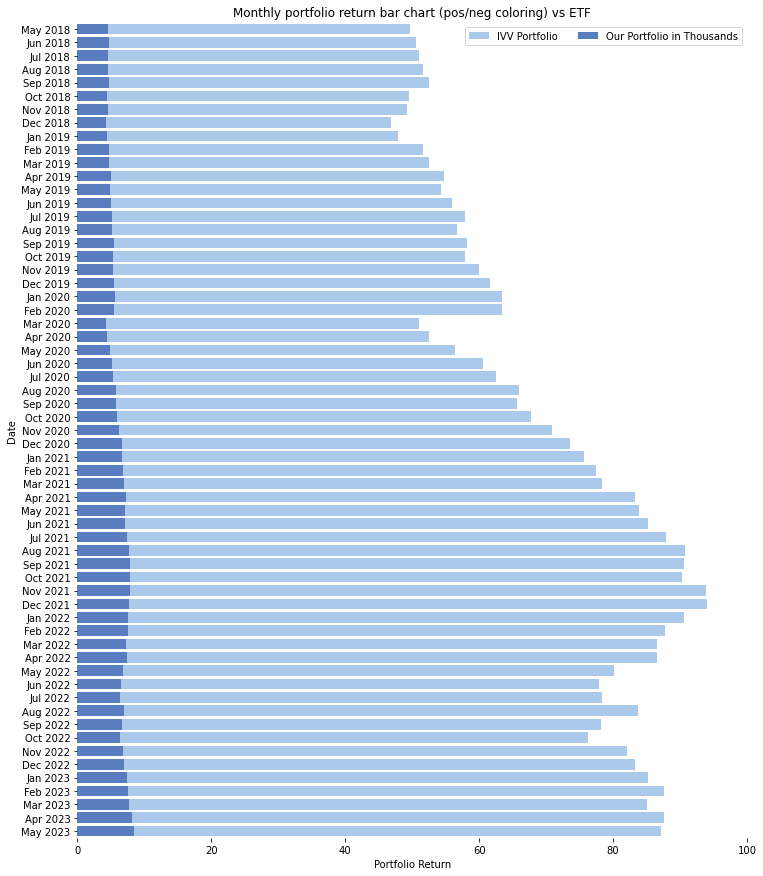

In [233]:
monthly_port_return = [
    # IVV Portfolio 
    {
        'color_codes': 'pastel',
        'x_values': ivv_port.get_etf_monthly_mean()["Portfolio Monthly Return"] / 1000,
        'y_values': [ts.strftime('%b %Y') for ts in ivv_port.get_etf_monthly_mean().index.tolist()],
        'data': ivv_port.get_etf_monthly_mean(),
        'label': "IVV Portfolio",
        'color': "b"
    },
    #Our Portfolio
    {
        'color_codes': 'muted',
        'x_values': ivv_port.get_weighted_port_monthly_mean()["Portfolio Monthly Return"] / 1000,
        'y_values': [ts.strftime('%b %Y') for ts in ivv_port.get_weighted_port_monthly_mean().index.tolist()],
        'data': ivv_port.get_weighted_port_monthly_mean(),
        'label': "Our Portfolio in Thousands",
        'color': "b"
    },
]
ivv_port.plot_information(plot_vars=monthly_port_return, ylabel="Date", xlabel="Portfolio Return",title='Monthly portfolio return bar chart (pos/neg coloring) vs ETF', figsize=(12,15), xlim=(0,100))

## Monthly return for long picks vs short picks vs ETF

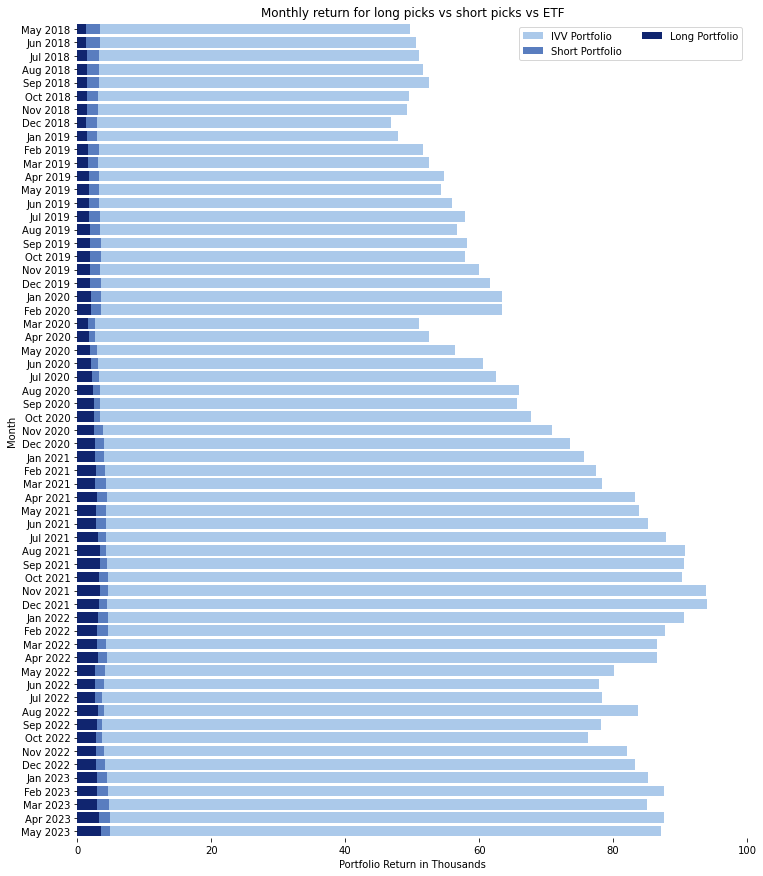

In [235]:
monthly_return_long_short_etf = [
    # IVV Portfolio 
    {
        'color_codes': 'pastel',
        'x_values': ivv_port.get_etf_monthly_mean()["Portfolio Monthly Return"] / 1000,
        'y_values': [ts.strftime('%b %Y') for ts in ivv_port.get_etf_monthly_mean().index.tolist()],
        'data': ivv_port.get_etf_monthly_mean(),
        'label': "IVV Portfolio",
        'color': "b"
    },
    # Short Portfolio
    {
        'color_codes': 'muted',
        'x_values': ivv_port.get_monthly_info(ivv_port.get_smallest_basket())["Portfolio Monthly Return"] / 1000,
        'y_values': [ts.strftime('%b %Y') for ts in ivv_port.get_monthly_info(ivv_port.get_smallest_basket()).index.tolist()],
        'data': ivv_port.get_monthly_info(ivv_port.get_smallest_basket()),
        'label': "Short Portfolio",
        'color': "b"
    },
    # Long Portfolio
    {
        'color_codes': 'dark',
        'x_values': ivv_port.get_monthly_info(ivv_port.get_largest_basket())["Portfolio Monthly Return"] / 1000,
        'y_values': [ts.strftime('%b %Y') for ts in ivv_port.get_monthly_info(ivv_port.get_largest_basket()).index.tolist()],
        'data': ivv_port.get_monthly_info(ivv_port.get_largest_basket()),
        'label': "Long Portfolio",
        'color': "b"
    },
]
ivv_port.plot_information(plot_vars=monthly_return_long_short_etf, ylabel="Month", xlabel="Portfolio Return in Thousands",title='Monthly return for long picks vs short picks vs ETF', figsize=(12,15), xlim=(0,100))


## Cumulative portfolio return vs ETF

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


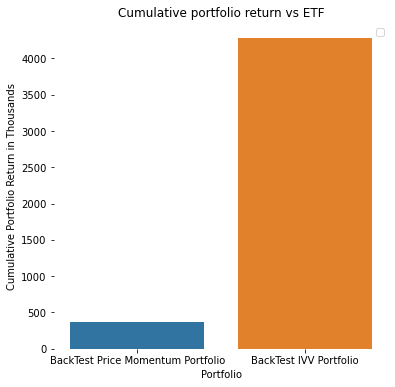

In [236]:
cumulative_return_port_etf = [
    # # IVV Portfolio 
    # {
    #     'color_codes': 'pastel',
    #     'x_values': "Portfolio Monthly Return",
    #     'y_values': [ts.strftime('%b %Y') for ts in ivv_port.get_etf_monthly_mean().index.tolist()],
    #     'data': ivv_port.get_backtest_comparison(),
    #     'label': "IVV Portfolio",
    #     'color': "b"
    # },
    # # Our Portfolio
    {
        'color_codes': 'muted',
        'y_values': ivv_port.get_backtest_comparison()['Final Cumulative Value'] / 1000,
        'x_values': ivv_port.get_backtest_comparison().index.tolist(),
        'data': ivv_port.get_backtest_comparison(),
        'label': None,
        'color': None
    },
    
]
ivv_port.plot_information(plot_vars=cumulative_return_port_etf, xlabel="Portfolio", ylabel="Cumulative Portfolio Return in Thousands",title='Cumulative portfolio return vs ETF', figsize=(6,6), xlim=None)
